In [1]:
import numpy as np
import pandas as pd
from rdflib import Graph, Literal, URIRef, Namespace
from rdflib.plugins.sparql import prepareQuery
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
%%time
effects = Graph()
effects.load('../TERA_OUTPUT/effects.nt',format='nt')

CPU times: user 5min 17s, sys: 5.68 s, total: 5min 23s
Wall time: 5min 22s


In [3]:
ONLY_ORGANIC = True

In [4]:
namespace = 'https://cfpub.epa.gov/ecotox/'

In [5]:
from rdflib.namespace import RDF, XSD

q = """
    select ?species ?chem ?conc ?unit ?time ?tunit where {
        ?test ns:hasResult [ns:endpoint ?end ;
                            ns:effect effect:MOR ;
                            ns:concentration [
                                rdf:value ?conc ;
                                unit:units ?unit 
                            ]] .
         ?test ns:studyDuration [
                    rdf:value ?time ;
                    unit:units ?tunit
                    ] .
        ?test ns:species ?species .
        ?test ns:chemical ?chem .
    filter (?unit in (unit:MicrogramPerLitre, unit:MilligramPerLitre))
    filter (?end in (endpoint:LC50, endpoint:LD50, endpoint:EC50) )
    #filter ((?tunit = "Hour" && (xsd:integer(?time) <= 96) && (xsd:integer(?time) >= 24)) || (?tunit = "Day" && (xsd:integer(?time) <= 4) && (xsd:integer(?time) >= 1)))
    }
    """

q = prepareQuery(q,
                 initNs = { 'ns': Namespace(namespace), 
                           'rdf':RDF,
                            'xsd':XSD,
                           'unit':Namespace('http://qudt.org/vocab/unit#'),
                           'endpoint':Namespace(namespace+'endpoint/'),
                            'effect':Namespace(namespace+'effect/')})


In [6]:
qres = effects.query(q)

In [7]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

query = """select ?cas ?mw where {
  ?c wdt:P231 ?castmp ;
     wdt:P2067 ?mw .
  bind(replace(?castmp,'-','') as ?cas)
}"""

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

results = get_results(endpoint_url, query)

mw = {}
for result in results["results"]["bindings"]:
    mw[namespace +'cas/'+ result['cas']['value']] = float(result['mw']['value'])

In [8]:

query = """select ?cas ?part where {
          ?chemical wdt:P527 ?part .
          ?chemical wdt:P231 ?castmp .
          bind(replace(?castmp,'-','') as ?cas)
  } """

applicability_domain = set()
results = get_results(endpoint_url, query)

from collections import defaultdict
r = defaultdict(set)
for result in results["results"]["bindings"]:
    r[namespace +'cas/'+ result['cas']['value']].add(result['part']['value'])

for k in r:
    if ONLY_ORGANIC and 'http://www.wikidata.org/entity/Q623' in r[k]:
        applicability_domain.add(k)
    elif not (ONLY_ORGANIC or 'http://www.wikidata.org/entity/Q623' in r[k]):
        applicability_domain.add(k)


In [9]:
data = []
j = 0
for i,row in enumerate(qres):
    a,c,b,u,t,tu = row
    tu = str(tu)
    t = float(t)
    if tu == 'Day':
        t *= 24
    elif tu == 'Hour':
        t *= 1
    else:
        continue
    if t > 96 or t < 24: continue
    try:
        f = 1e6 if 'Micro' in str(u) else 1e3
        data.append((str(a),str(c),float(b)/f/mw[str(c)],t))
    except:
        j += 1
len(data),j

(10833, 1338)

In [10]:
data = pd.DataFrame(data=dict(zip(['species','chemical','conc (mol/L)','time'],zip(*data))))
data = data[data['chemical'].isin(applicability_domain)]
idx = (data.groupby(['species','chemical']).count() >= 3).index.tolist()
data = data.set_index(['species','chemical'])
data = data.loc[data.index.isin(idx)].reset_index()

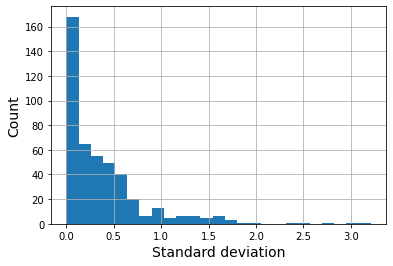

In [13]:
data['log conc (mol/L)'] = -np.log10(data['conc (mol/L)'])

data.groupby(['species','chemical']).std().hist(bins=25, column = 'log conc (mol/L)')
plt.title('')
plt.xlabel('Standard deviation',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.savefig('only_organic_experiment_std.png' if ONLY_ORGANIC else 'experiment_std.png')

In [ ]:
tmp = data.groupby(['species','chemical']).median()[['log conc (mol/L)']]
effect_data = list(zip(*list(zip(*tmp.index.values)),tmp.values.ravel()))
df = pd.DataFrame(data=dict(zip(['species','chemical','log conc (mol/L)'],zip(*effect_data))))
df.to_csv('only_organic_effect_data.csv' if ONLY_ORGANIC else 'effect_data.csv')

In [ ]:
df.shape